In [116]:
import argparse
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from utils import normalize_1D, Account, MACD_method

warnings.filterwarnings('ignore')
sns.set_style("white")

In [117]:
def returnScore(arg, info_df):
    df = info_df[78: -2]
    bit_trade_score  = normalize_1D(arg.w_b_price * normalize_1D(df['d Bit'].values)  + arg.w_b_bull * normalize_1D(df['Bit Bull Market'].values)  - arg.w_b_risk * normalize_1D(np.exp(df['Bit Risk'].values)))

    gold_trade_score = normalize_1D(arg.w_g_price * normalize_1D(df['d Gold'].values) + arg.w_g_bull * normalize_1D(df['Gold Bull Market'].values) - arg.w_g_risk * normalize_1D(np.exp(df['Gold Risk'].values)))
    return normalize_1D(bit_trade_score), normalize_1D(gold_trade_score)


def buyStrategy(b_score, g_score, b_act, g_act, arg):
    amount = [0, 0]

    if b_act == 1 and np.exp(b_score) > arg.h_b_buy:
        amount[0] = arg.n_b_trans * np.exp(b_score)
    elif b_act == -1 and np.exp(-b_score) > arg.h_b_sell:
        amount[0] = - arg.n_b_trans * np.exp(-b_score)

    # elif np.exp(b_score) > 2 * arg.alpha_b * arg.k_a_b:
    #     amount[0] = arg.n_b_trans * np.exp(2 * b_score) / 2
    # elif np.exp(-b_score) > 2 * arg.alpha_b * arg.k_a_b:
    #     amount[0] = - arg.n_b_trans * np.exp(2 * b_score) / 2
    
    if g_act == 1 and np.exp(g_score) > arg.h_g_buy:
        amount[1] = arg.n_g_trans * np.exp(g_score)
    elif g_act == -1 and np.exp(-g_score) > arg.h_g_sell:
        amount[1] = - arg.n_g_trans * np.exp(-g_score)

    # elif np.exp(b_score) > 2 * arg.alpha_b * arg.k_a_b:
    #     amount[0] = arg.n_b_trans * np.exp(2 * b_score) / 2
    # elif np.exp(-b_score) > 2 * arg.alpha_b * arg.k_a_b:
    #     amount[0] = - arg.n_b_trans * np.exp(2 * b_score) / 2
    
    return amount

# def buyStrategy(b_score, g_score, b_act, g_act, arg):
#     amount = [0, 0]

#     if np.exp(b_score) > arg.alpha_b * arg.k_a_b:
#         amount[0] = arg.n_b_trans * np.exp(b_score)
#     elif np.exp(-b_score) > arg.alpha_b * arg.k_a_b:
#         amount[0] = - arg.n_b_trans * np.exp(-b_score)

#     # elif np.exp(b_score) > 2 * arg.alpha_b * arg.k_a_b:
#     #     amount[0] = arg.n_b_trans * np.exp(2 * b_score) / 2
#     # elif np.exp(-b_score) > 2 * arg.alpha_b * arg.k_a_b:
#     #     amount[0] = - arg.n_b_trans * np.exp(2 * b_score) / 2
    
#     if np.exp(g_score) > arg.alpha_g * arg.k_a_g:
#         amount[1] = arg.n_g_trans * np.exp(g_score)
#     elif np.exp(-g_score) > arg.alpha_g * arg.k_a_g:
#         amount[1] = - arg.n_g_trans * np.exp(-g_score)

#     # elif np.exp(b_score) > 2 * arg.alpha_b * arg.k_a_b:
#     #     amount[0] = arg.n_b_trans * np.exp(2 * b_score) / 2
#     # elif np.exp(-b_score) > 2 * arg.alpha_b * arg.k_a_b:
#     #     amount[0] = - arg.n_b_trans * np.exp(2 * b_score) / 2
    
#     return amount

def trade(b_act, g_act, df_info, arg, isPrint = False):
    account = Account(df_info, a_g=arg.alpha_g, a_b=arg.alpha_b)
    b_score, g_score = returnScore(arg, df_info)
    for day in range(len(b_score)):
        account.setDay(day)
        amount = buyStrategy(b_score[day], g_score[day], b_act[day], g_act[day], arg)
        if amount[0] > 0:
            account.buyBit(amount[0])
        elif amount[0] < 0:
            account.sellBit(-amount[0])
        if account.isGoldOpen():
            if amount[1] > 0:
                account.buyGold(amount[1])
            elif amount[1] < 0:
                account.sellGold(-amount[1])
        account.writeState()
        if isPrint:
            print(account.getState())
    return account

def noisyTrade(b_act, g_act, df_info, arg, noisy_std = 0.1, inverse = 0.05, isPrint = False):
    account = Account(df_info, a_g=arg.alpha_g, a_b=arg.alpha_b)
    b_score, g_score = returnScore(arg, df_info)
    for day in range(len(b_score)):
        account.setDay(day)
        amount = buyStrategy(b_score[day], g_score[day], b_act[day], g_act[day], arg)
        if amount[0] > 0:
            if np.random.random() < inverse:
                account.sellBit(np.abs(amount[0] * np.random.normal(1, noisy_std)))
            else:
                account.buyBit(np.abs(amount[0] * np.random.normal(1, noisy_std)))
        elif amount[0] < 0:
            if np.random.random() < inverse:
                account.buyBit(np.abs(-amount[0] * np.random.normal(1, noisy_std)))
            else:
                account.sellBit(np.abs(-amount[0] * np.random.normal(1, noisy_std)))
        if account.isGoldOpen():
            if amount[1] > 0:
                if np.random.random() < inverse:
                    account.sellGold(np.abs(-amount[1] * np.random.normal(1, noisy_std)))
                else:
                    account.buyGold(np.abs(amount[1] * np.random.normal(1, noisy_std)))
            elif amount[1] < 0:
                if np.random.random() < inverse:
                    account.buyGold(np.abs(amount[1] * np.random.normal(1, noisy_std)))
                else:
                    account.sellGold(np.abs(-amount[1] * np.random.normal(1, noisy_std)))
        account.writeState()
        if isPrint:
            print(account.getState())
    return account

In [118]:
df = pd.read_csv('input\Price with Feature.csv').drop(columns='Unnamed: 0')
df

,Date,Mask,Bit Day 1,Bit Day 2,Bit Day 3,Bit Price,Gold Day 1,Gold Day 2,Gold Day 3,Gold Price,...,Gold 20 Days BIAS,Bit 5 Days BIAS,Gold Bull Market,Bit Bull Market,Gold Risk,Bit Risk,Org Bit Price,Org Gold Price,Bit ARIMA,Gold ARIMA
0,0,1,NaN,NaN,NaN,-0.999124,NaN,NaN,NaN,-0.577460,...,NaN,NaN,NaN,NaN,NaN,NaN,621.65,1324.60,NaN,NaN
1,1,1,NaN,NaN,NaN,-0.999505,NaN,NaN,NaN,-0.579478,...,NaN,NaN,NaN,NaN,NaN,NaN,609.67,1323.65,NaN,NaN
2,2,1,NaN,NaN,NaN,-0.999465,NaN,NaN,NaN,-0.583515,...,NaN,NaN,NaN,NaN,NaN,NaN,610.92,1321.75,NaN,NaN
3,3,1,NaN,NaN,NaN,-0.999532,NaN,NaN,NaN,-0.606777,...,NaN,NaN,NaN,NaN,NaN,NaN,608.82,1310.80,NaN,NaN
4,4,1,NaN,NaN,NaN,-0.999482,NaN,NaN,NaN,-0.611982,...,NaN,0.090712,NaN,NaN,NaN,NaN,610.38,1308.35,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1821,1821,1,49963.703,50515.168,49750.105,0.625625,1822.7340,1825.5347,1816.0897,0.437039,...,0.045283,0.215902,-0.105108,0.128691,0.142150,-0.094190,51769.06,1802.15,50072.36646,1821.329802
1822,1822,1,52389.690,50168.902,50638.707,0.654480,1804.0776,1823.8490,1826.6033,0.402730,...,-0.069940,0.223433,-0.125333,0.142031,0.186738,-0.107890,52677.40,1786.00,51679.12840,1801.359618
1823,1823,1,52591.844,52239.617,50342.945,0.468069,1788.1604,1805.5062,1824.9523,0.407510,...,-0.057298,-0.120403,-0.136372,-0.023378,0.193904,0.118321,46809.17,1788.25,52766.34103,1783.685169
1824,1824,1,45305.260,52467.312,52167.664,0.444855,1789.7795,1789.6935,1806.7588,0.421000,...,-0.018005,-0.119981,-0.132047,-0.031114,0.181038,0.125188,46078.38,1794.60,47402.07874,1787.787001


In [119]:
df = pd.read_csv('input\Price with Feature.csv').drop(columns='Unnamed: 0')
df['d Bit'] = np.nan
df['d Bit'][1:] = df['Bit ARIMA'].values[1:] - df['Org Bit Price'].values[:-1]
df['d Gold'] = np.nan
df['d Gold'][1:] = df['Gold ARIMA'].values[1:] - df['Org Gold Price'].values[:-1]

is_load = True
if is_load:
    act_b = np.load('input/act_b.npy')
    act_g = np.load('input/act_b.npy')
else:
    bit_df = pd.read_csv('input\Bitcoin Price.csv')
    macd = MACD_method(bit_df, 'Value')
    macd.processing()
    macd.get_strategy()
    bit_actions = bit_df['Choice'].values

    gold_df = pd.read_csv('input\Gold Price.csv')
    macd = MACD_method(gold_df, 'USD (PM)')
    macd.processing()
    macd.get_strategy()
    temp_gold_actions = gold_df['Choice'].values

    index = 0
    gold_actions = np.zeros(len(df))
    for i, mask in enumerate(df['Mask'].values):
        if mask:
            gold_actions[i] = temp_gold_actions[index]
            index += 1

    act_b = bit_actions[78: -2].astype(np.int0)
    act_g = gold_actions[78: -2].astype(np.int0)
    np.save('input/act_b.npy', act_b)
    np.save('input/act_g.npy', act_g)


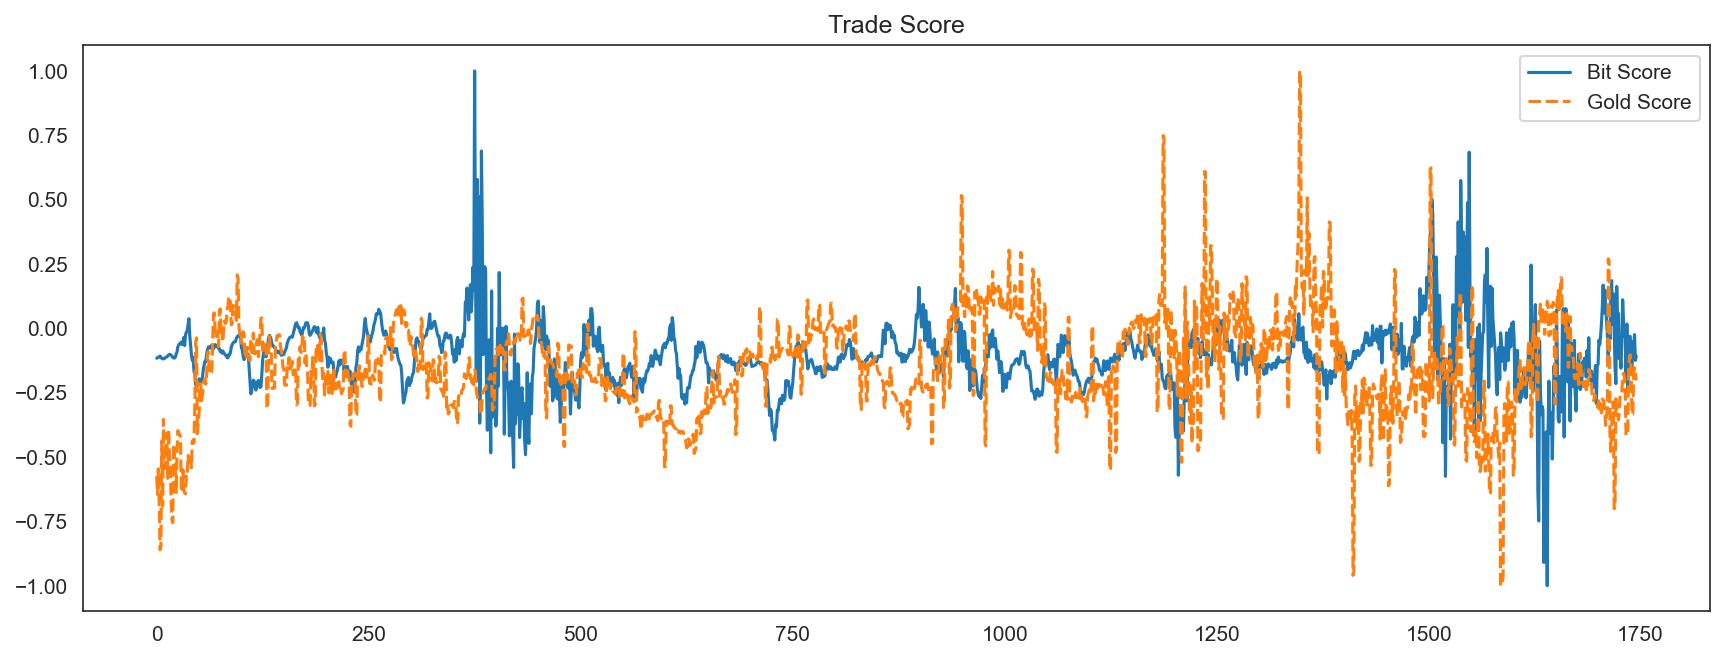

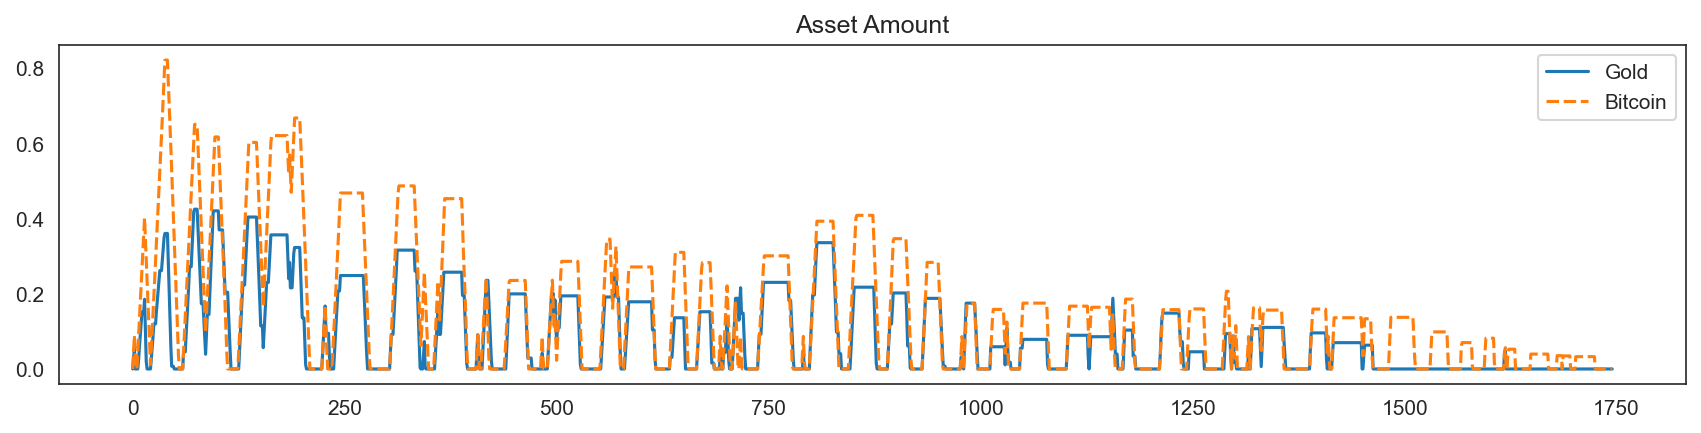

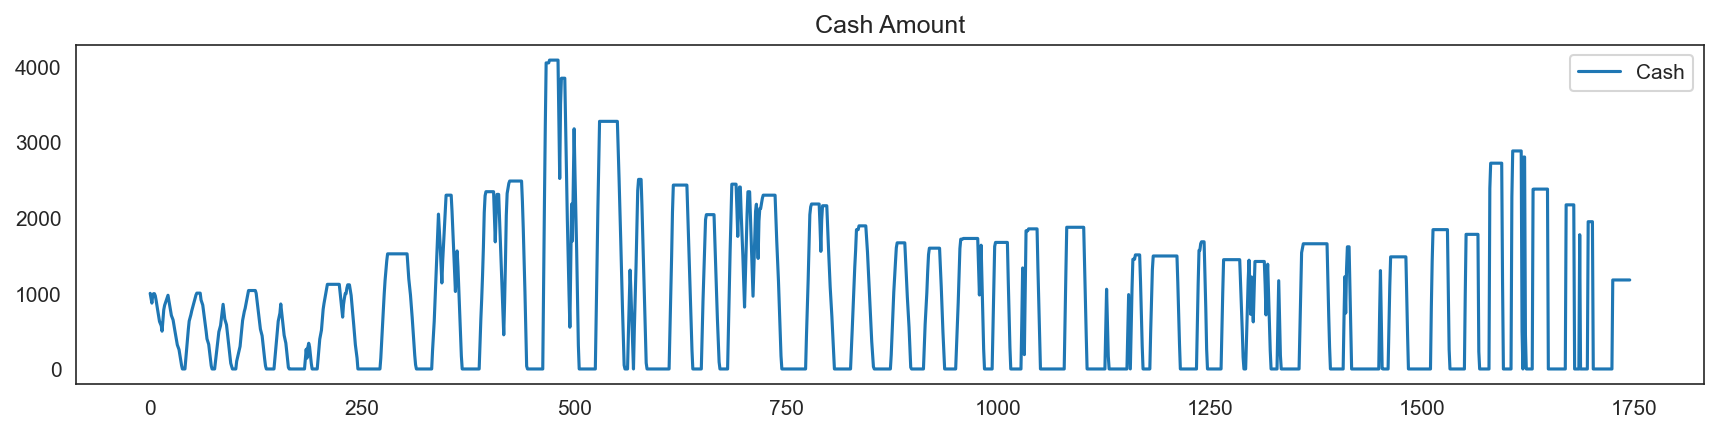

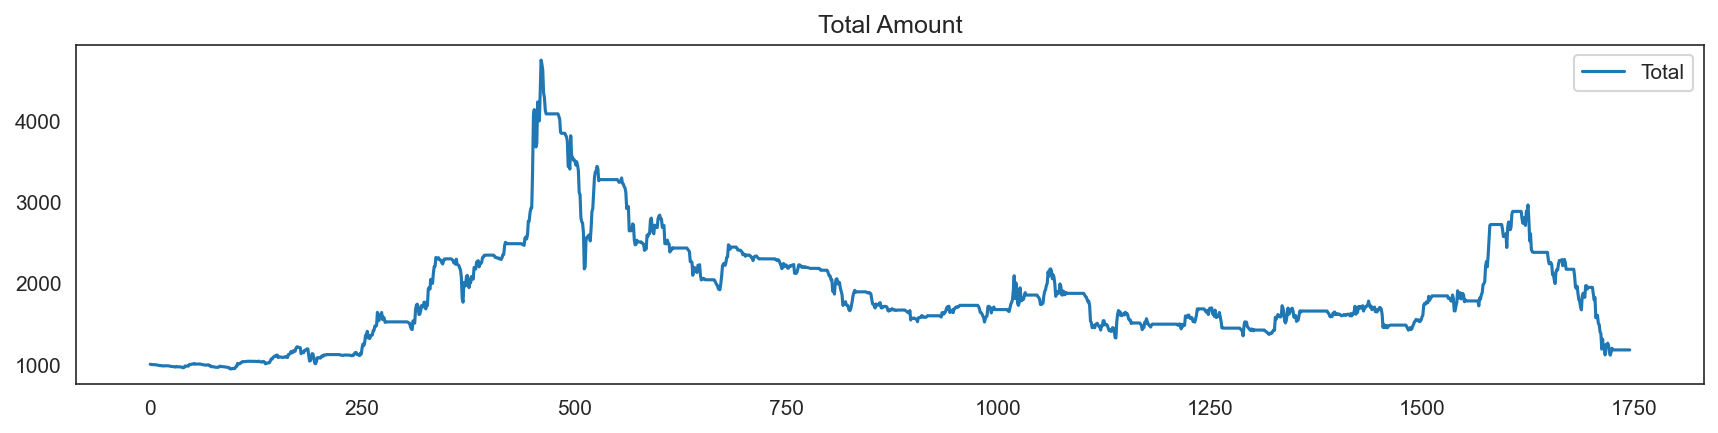

1176.7202648077462


In [124]:
parser = argparse.ArgumentParser()
# ######################################################################
# ######################################################################
# ######################################################################
# parser.add_argument('--alpha_b', type = float, default = 0.02)
# parser.add_argument('--alpha_g', type = float, default = 0.01)

# # Related to score value
# parser.add_argument('--w_b_price', type = float, default = 10)
# parser.add_argument('--w_b_bull', type = float, default = 3)
# parser.add_argument('--w_b_risk', type = float, default = 2)

# # Related to trade strategy
# parser.add_argument('--w_g_price', type = float, default = 10)
# parser.add_argument('--w_g_bull', type = float, default = 4)
# parser.add_argument('--w_g_risk', type = float, default = 5)

# # How much to be traded
# parser.add_argument('--n_b_trans', type = float, default = 0.024)
# parser.add_argument('--n_g_trans', type = float, default = 0.02)

# parser.add_argument('--k_a_b', type = float, default = 53)
# parser.add_argument('--k_a_g', type = float, default = 135)
# ######################################################################
# ######################################################################
# ######################################################################

parser.add_argument('--alpha_b', type = float, default = 0.02)
parser.add_argument('--alpha_g', type = float, default = 0.01)

# Related to score value
parser.add_argument('--w_b_price', type = float, default = 100)
parser.add_argument('--w_b_bull', type = float, default = 42)
parser.add_argument('--w_b_risk', type = float, default = 20)

# Related to trade strategy
parser.add_argument('--w_g_price', type = float, default = 100)
parser.add_argument('--w_g_bull', type = float, default = 42)
parser.add_argument('--w_g_risk', type = float, default = 20)

# How much to be traded
parser.add_argument('--n_b_trans', type = float, default = 0.05)
parser.add_argument('--n_g_trans', type = float, default = 0.05)

parser.add_argument('--h_b_buy', type = float, default = 0)
parser.add_argument('--h_b_sell', type = float, default = -0.25)
parser.add_argument('--h_g_buy', type = float, default = 0.1)
parser.add_argument('--h_g_sell', type = float, default = -0.5)


args = parser.parse_args(args=[])

b_score, g_score = returnScore(args, df)

my_pocket = trade(act_b, act_g, df, args)

plt.figure(figsize=(14, 5), dpi=150)
plt.legend('best')
sns.lineplot(data=pd.DataFrame({'Bit Score': b_score, 'Gold Score': g_score}))
plt.title('Trade Score')
plt.savefig('results\Trading\Trade Score.png')
plt.show()

plt.figure(figsize=(14, 3), dpi=150)
plt.legend('best')
sns.lineplot(data=pd.DataFrame(my_pocket.track)[['Gold', 'Bitcoin']])
plt.title('Asset Amount')
plt.savefig('results\Trading\Asset Amount.png')
plt.show()

plt.figure(figsize=(14, 3), dpi=150)
plt.legend('best')
sns.lineplot(data=pd.DataFrame(my_pocket.track)[['Cash']])
plt.title('Cash Amount')
plt.savefig('results\Trading\Cash Amount.png')
plt.show()

plt.figure(figsize=(14, 3), dpi=150)
plt.legend('best')
sns.lineplot(data=pd.DataFrame(my_pocket.track)[['Total']])
plt.title('Total Amount')
plt.savefig('results\Trading\Total Amount.png')
plt.show()

print(my_pocket.getState()['Total'])


In [121]:
# asset = trade(act_b, act_g, df, args).getState()['Total']
# print(asset)
# money = []
# for _ in tqdm(range(1000)):
#     money.append(noisyTrade(act_b, act_g, df, args, noisy_std=0.1, inverse=0.15).getState()['Total'])
# sns.displot(data=money, bins=150)
# plt.title('Noisy Trade')
# plt.plot([asset] * 300,np.linspace(0,35,300),'r')
# plt.savefig('results/Trading/Noisy Trade.png')
# plt.show()
# (np.array(money) > asset).sum() / len(money)

100%|██████████| 100/100 [00:02<00:00, 40.23it/s]


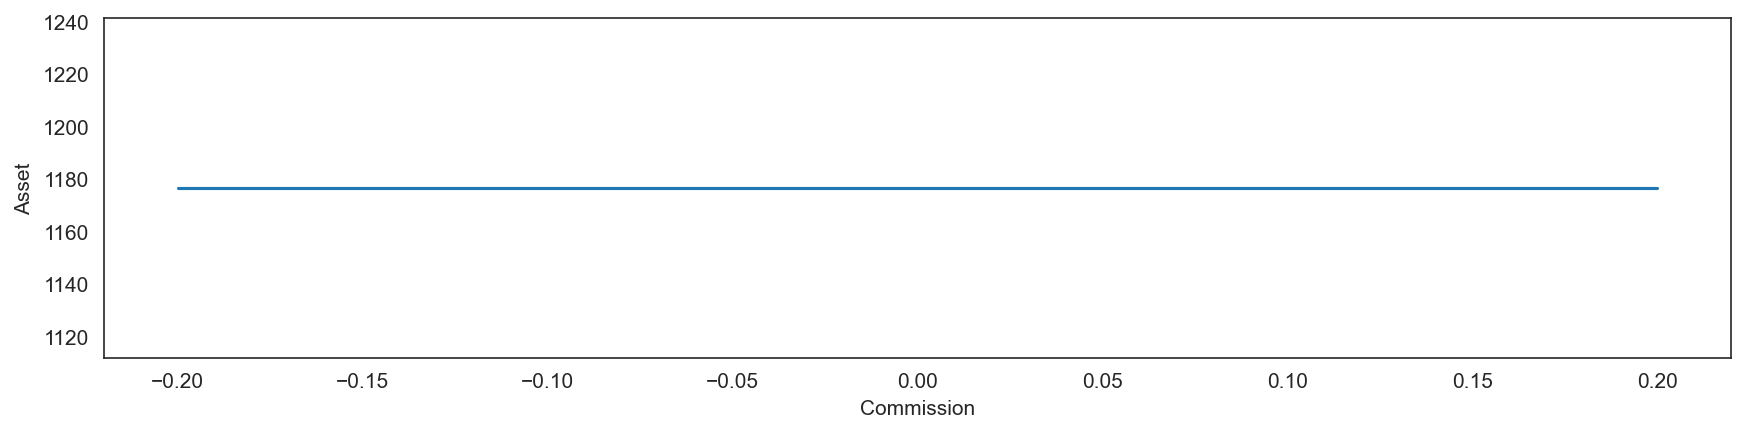

-0.2


In [125]:
result = []
space = np.linspace(-0.2, 0.2, 100)
for i in tqdm(space):
    parser = argparse.ArgumentParser()

    parser.add_argument('--alpha_b', type = float, default = 0.02)
    parser.add_argument('--alpha_g', type = float, default = 0.01)

    # Related to score value
    parser.add_argument('--w_b_price', type = float, default = 100)
    parser.add_argument('--w_b_bull', type = float, default = 42)
    parser.add_argument('--w_b_risk', type = float, default = 20)

    # Related to trade strategy
    parser.add_argument('--w_g_price', type = float, default = 100)
    parser.add_argument('--w_g_bull', type = float, default = 42)
    parser.add_argument('--w_g_risk', type = float, default = 20)

    # How much to be traded
    parser.add_argument('--n_b_trans', type = float, default = 0.05)
    parser.add_argument('--n_g_trans', type = float, default = 0.05)

    parser.add_argument('--h_b_buy', type = float, default = 0)
    parser.add_argument('--h_b_sell', type = float, default = i)
    parser.add_argument('--h_g_buy', type = float, default = 0.1)
    parser.add_argument('--h_g_sell', type = float, default = -0.5)

    args = parser.parse_args(args=[])

    b_score, g_score = returnScore(args, df)

    my_pocket = trade(act_b, act_g, df, args)

    result.append(my_pocket.getState()['Total'])
    
plt.figure(figsize=(14, 3), dpi=150)
sns.lineplot(data=pd.DataFrame({'Asset': result, 'Commission': space}), x='Commission', y='Asset')
plt.savefig('results\Trading\Commission of gold.jpg')
plt.show()
print(space[np.array(result).argmax()])

100%|██████████| 100/100 [00:01<00:00, 57.21it/s]


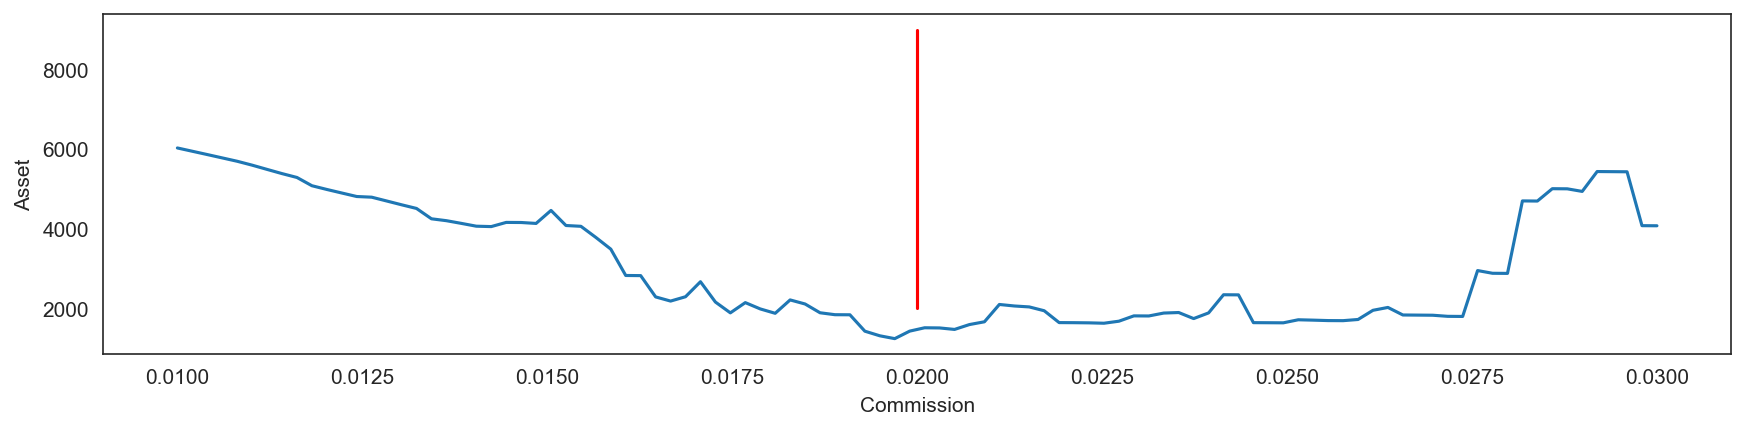

0.01


In [ ]:
result = []
space = np.linspace(0.01, 0.03, 100)
for i in tqdm(space):
    parser = argparse.ArgumentParser()

    parser.add_argument('--alpha_b', type = float, default = i)
    parser.add_argument('--alpha_g', type = float, default = 0.01)

    # Related to score value
    parser.add_argument('--w_b_price', type = float, default = 10)
    parser.add_argument('--w_b_bull', type = float, default = 3)
    parser.add_argument('--w_b_risk', type = float, default = 2)

    # Related to trade strategy
    parser.add_argument('--w_g_price', type = float, default = 10)
    parser.add_argument('--w_g_bull', type = float, default = 4)
    parser.add_argument('--w_g_risk', type = float, default = 5)

    # How much to be traded
    parser.add_argument('--n_b_trans', type = float, default = 0.024)
    parser.add_argument('--n_g_trans', type = float, default = 0.02)

    parser.add_argument('--k_a_b', type = float, default = 55)
    parser.add_argument('--k_a_g', type = float, default = 135)

    args = parser.parse_args(args=[])

    b_score, g_score = returnScore(args, df)

    my_pocket = trade(act_b, act_g, df, args)

    result.append(my_pocket.getState()['Total'])
    
plt.figure(figsize=(14, 3), dpi=150)
sns.lineplot(data=pd.DataFrame({'Asset': result, 'Commission': space}), x='Commission', y='Asset')
plt.plot([0.02] * 300, np.linspace(2000, 9000, 300),'r')
plt.savefig('results\Trading\Commission of bitcoin.jpg')
plt.show()
print(space[np.array(result).argmax()])